In [1]:
import pandas as pd
import numpy as np

## Clean up

Students should start by **deleting** the temp and output folders if they exist, then create new temp and output folders. If you need any additional inputs not provided by the professor, either (A) download them to inputs and use that way or (B) download them via python/pandas every time. If you go route (A), put the download inside an `if` statement that only runs when the file doesn't exist. 

## Data

### Load and combine firm data and stock returns

Data on returns and firms are obtained from CRSP and Compustat. The raw data was filtered to 2006, and the returns data was reduced to firms in Compustat to shrink the necessary file size. 

In [2]:
# load data 

stocks = pd.read_stata('https://github.com/LeDataSciFi/lectures-spr2020/blob/master/assignment_data/stocks_2006.dta?raw=true')
stocks.name = "Stocks"
firms = pd.read_stata('firms_2006.dta')   # students should move this into an input folder and load from there!
firms.name = "Firms"

In [3]:
# explore data

for df in [stocks,firms]:
    print("\n\n\n","="*70,"\n","EXAMINING: ",df.name,"\n","="*70)
    print("\nHead\n\n",df.head())
    print("\nTail\n\n",df.tail())
    print("\nshape\n\n",df.shape)
    print("\nInfo\n\n",df.info())
    print("\nSummary Stats\n\n",df.describe())
    #print("\n# of unique values\n\n",df.nunique())
    
# these are categorical variables... let's see what's in them

print(firms['gsector'].value_counts()) # OYE! pandas imported the blank values, but they aren't "missing" 
print(firms['state'].value_counts())   # per the above "describe's" output. Let's keep this in mind...




 EXAMINING:  Stocks 

Head

     permno       date       ret
0  10001.0 2006-01-03 -0.001031
1  10001.0 2006-01-04  0.011352
2  10001.0 2006-01-05 -0.025510
3  10001.0 2006-01-06 -0.015812
4  10001.0 2006-01-09 -0.050963

Tail

           permno       date       ret
1535251  93105.0 2006-12-22  0.000000
1535252  93105.0 2006-12-26  0.001653
1535253  93105.0 2006-12-27  0.029015
1535254  93105.0 2006-12-28 -0.009646
1535255  93105.0 2006-12-29 -0.032468

shape

 (1535256, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1535256 entries, 0 to 1535255
Data columns (total 3 columns):
permno    1535256 non-null float64
date      1535256 non-null datetime64[ns]
ret       1523298 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 46.9 MB

Info

 None

Summary Stats

              permno           ret
count  1.535256e+06  1.523298e+06
mean   7.401086e+04  7.630558e-04
std    2.274953e+04  2.806116e-02
min    1.000100e+04 -8.019802e-01
25%    7.538300e+04 -9.758054e-03


In [4]:
print("There are",len(stocks['permno']),"obs in the stock data",
      "covering",stocks['permno'].nunique(),"unique stocks.")
print("")
print("There are",len(firms['permno']),"obs in the firm data",
      "covering",firms['permno'].nunique(),"unique stocks.")


There are 1535256 obs in the stock data covering 6311 unique stocks.

There are 6318 obs in the firm data covering 6318 unique stocks.


In [5]:
# lets merge the data in

stocks['year'] = stocks['date'].dt.year 
                 # in this homework, you could just merge on permno, but going forward, we will
                 # have multiple years, so you'll merge on firm-year. I've called this "year"
                 # and not "fyear" because these are CALENDAR DATES. 
sample = pd.merge(left=stocks,right=firms,
                  left_on=['permno','year'],right_on=['permno','fyear'], # stock data on cal year, firm data on fiscal year
                  how='inner')

# whats the sample size now?

print("There are",len(sample['permno']),"obs in the combined data",
      "covering",sample['permno'].nunique(),"unique stocks.") 
     # we kept the entire stock dataset, but lost some of the firm in the firms data... 
     # either they had no traded stock, CRSP didn't cover, or our "permno" identifier wasn't consistent across both

There are 1535256 obs in the combined data covering 6311 unique stocks.


### Sample restrictions

This project is curious about how risk and return vary by industry and a firm's home state. To make it a bit simpler to analyze, we are going to focus on IT and Finance firms in California and New York.

In [6]:
sample = sample.query('state in ["CA","NY"] & gsector in ["40","45"]') 
    # gsector's are in quotes because that variable is an object (ie string), not a number type. 
    
print("There are",len(sample['permno']),"obs in the industry-state subsample",
      "covering",sample['permno'].nunique(),"unique stocks. \n") 
# print(sample)    

# output will be much easier for readers if we name the industry instead of reporting an industry

sample.loc[sample['gsector']=="40",'ind'] = "Finance"
sample.loc[sample['gsector']=="45",'ind'] = "IT"

There are 152051 obs in the industry-state subsample covering 624 unique stocks. 



## Examining the daily returns

This section builds "T1" in the assignment prompt, though I separated the table for visual clarity.

**The number of observations and firms in each state-industry**

- CA is a much more common home for IT firms than NY
- Slightly more finance firms in NY than CA
- Firms in NY are more likely to be in Finance than IT

In [7]:
(sample.pivot_table(index='ind',columns='state',values='permno',
                    aggfunc=['nunique','count']) # lambda x: x.count()//x.nunique() <-- obs per firm ~ 245
                    .stack(level=0)
).style.format("{:,.0f}") # specify format! here, show commas for thousands

**Daily return characteristics by state-industry**

Key observations:
- NY Finance firms have the highest average returns
- IT has more variance than Finance in both states
- Seems there are some large outliers (300% return!) which indicates that we should clean the data in some way. Common filters in asset pricing tests: exclude penny stocks, keep only common shares, US firms only, no ADRs. 

_Note: Statistics below are reported as daily **percent** returns. (I.e. 0.06 means 0.06%, or 0.0006.)_

In [8]:
(sample.assign(ret=sample['ret']*100)
       .pivot_table(index='ind',columns='state',values='ret',
                    aggfunc=['mean','std']) # lambda x: x.count()//x.nunique() <-- obs per firm ~ 245
       .stack(level=0)
).style.format("{:.3f}")

In [9]:
(sample.assign(ret=sample['ret']*100)
       .pivot_table(index='gsector',columns='state',values='ret',
                    aggfunc=['max','min']) # lambda x: x.count()//x.nunique() <-- obs per firm ~ 245
       .stack(level=0)
).style.format("{:.2f}")

## Examining annual returns

This section builds up to "T2" in the assignment prompt

### How to compute annual returns

Let $r_t = (P_t+D_t)/P_{t-1}$ be the simple return for a single period with dividends included. 

Let $R_t = (1+r_t)$ be the **gross** (thus, the capital "R") return for a single period.

Then the gross return for a number of periods is

\begin{equation}
R[0,T] = \prod_{t=1}^T R_t
\end{equation}

and the return for the same set of periods is simply the above minus 1.

\begin{align}
r[0,T] = & R[0,T] - 1  \\
= & (\prod_{t=1}^T R_t) - 1
\end{align}

There is one more way to compute the gross return: "Sum the log returns, then exponentiate":

\begin{align}
R[0,T] = & \prod_{t=1}^T R_t \\
       = & \prod_{t=1}^T ( e(ln( R_t))        ) \\
       = & e(\sum_{t=1}^T ln(R_t)) \\
\end{align}
the second line works because $e(ln(x))=x$ and the last line works because $e^a*e^b*e^c=e^{a+b+c}$.

In [10]:
%%timeit
# approach #1: multiply all the gross returns, subtract one
(sample.assign(ret=sample['ret']+1) # now we have R(t) for each observation
       .groupby('permno')['ret']    # for each firm,
       .prod()                      # multiple all the gross returns
       -1                           # and subtract one to get back to the total period return
)

21 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
# approach #2 (equivalent): sum the log returns, then exponentiate and subtract 1
(sample.assign(ret=np.log(sample['ret']+1)) # now we have log(R(t)) for each observation
       .groupby('permno')['ret']            # for each firm,  
       .sum()                               # sum the log gross returns
       .apply(np.exp)-1                     # exp and subtract one
)

19.7 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


_(Seems like they are roughly the same speed.)_

### How to compute annual standard deviation

If $\sigma_d$ is the standard deviation of daily returns, and we assume there is 
250 trading days in a year, then the annualized standard deviation is simply $\sigma_y = \sqrt{250}*\sigma_d$.

### Calculating annual measures

This step will take our firm-day return structure and create a firm-year structure.

In [12]:
annual = pd.DataFrame() # open an empty dataframe
annual['ret'] = (sample.assign(ret=sample['ret']+1) # now we have R(t) for each observation
                       .groupby('permno')['ret']    # for each firm,
                       .prod()                      # multiple all the gross returns
                       -1                           # and subtract one to get back to the total period return
)
annual['std'] = sample.groupby('permno')['ret'].std().mul(np.sqrt(250))

# we want our industry and state variables still!
annual['state'] = sample.groupby('permno')['state'].first()
annual['ind']   = sample.groupby('permno')['ind'].first()

In [13]:
annual.describe()


,ret,std
count,624.000000,621.000000
mean,0.134586,0.408751
std,0.378569,0.273974
min,-0.750063,0.092263
25%,-0.088569,0.252500
50%,0.094937,0.372133
75%,0.311344,0.504754
max,2.363395,5.157897


### The distribution of annual returns - T2

`Describe` gives use a lot of statistics, but perhaps we should also examine skewness and kurtosis and the 10th and 90th percentiles! To do so, we would probably write a function that returned "describe", along with those stats.

In [14]:
(annual.pivot_table(index='ind',columns='state',values=['ret'],
                    aggfunc='describe') # lambda x: x.count()//x.nunique() <-- obs per firm ~ 245
       .stack(level=1).unstack(level=0) # move the stats to rows, then move the states up to super columns
).reindex(labels=['count','mean','std','min','25%', '50%', '75%',  'max'] # change the order of rows
).style.format("{:.3f}")

### The distribution of standard deviation

Observations:
- Either one CA IT firm had turbulent year like nothing else, or this is a data issue...
- IT in general was more volatile

In [15]:
(annual.pivot_table(index='ind',columns='state',values=['std'],
                    aggfunc=['describe']) # lambda x: x.count()//x.nunique() <-- obs per firm ~ 245
       .stack(level=2).unstack(level=0) # move the stats to rows, then move the states up to super columns
).reindex(labels=['count','mean','std','min','25%', '50%', '75%',  'max'] # change the order of rows
).style.format("{:.3f}")

## Bonus Figure

In [16]:
import seaborn as sns

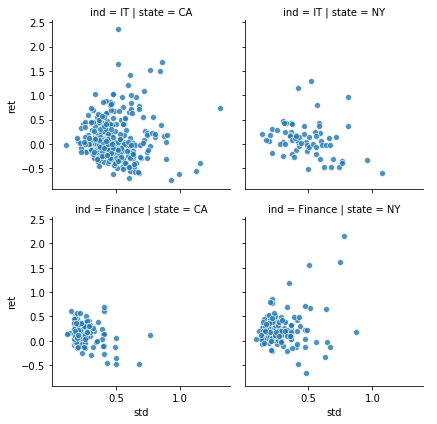

In [17]:
(annual
 .query('std<1.5') # throw out two outliers that distort the figures
 .pipe((sns.FacetGrid, 'data'),
       row='ind', col='state', 
       legend_out=True) # set up 4 sub-figures
 .map(sns.scatterplot, 'std', 'ret', alpha=0.8) 
 .add_legend())

## Q1: Which firm in each industry-state had the best month within the year? (Again: Compute exact monthly returns from the daily.)

### Calculate monthly return data

In [18]:

monthly = pd.DataFrame() # open an empty dataframe

monthly['mret'] = (sample.assign(ret=sample['ret']+1) # now we have R(t) for each observation
                       .assign(month = sample['date'].dt.month) # get the month
                       .groupby(['permno','year','month'])['ret']    # for each firm,
                       .prod()                      # multiple all the gross returns
                       -1                           # and subtract one to get back to the total period return
)

# we want our industry and state variables still!
monthly['state'] = sample.assign(month = sample['date'].dt.month)\
                         .groupby(['permno','year','month'])['state'].first()
monthly['ind']   = sample.assign(month = sample['date'].dt.month)\
                         .groupby(['permno','year','month'])['ind'].first()

### Report best months

In [19]:
(monthly.reset_index() # pop permno out from index to variable, else the .agg function can't see it below
     .sort_values(['state','ind','mret'],ascending=False) # sort so highest return first
     .groupby(['state','ind'])  
     .agg(lambda x: x.iloc[0]) # keep the first (highest return) 
     [['permno','mret']] # keep only the return
)

permno      mret
state ind                       
CA    Finance  86367.0  0.359722
      IT       91435.0  3.135714
NY    Finance  81254.0  0.554569
      IT       89941.0  0.967314

## Q2: Same, but look for the worst month?

In [20]:
(monthly.reset_index() # pop permno out from index to variable, else the .agg function can't see it below
     .sort_values(['state','ind','mret'],ascending=True) # sort so lowest return first
     .groupby(['state','ind'])  
     .agg(lambda x: x.iloc[0]) # keep the first (highest return) 
     [['permno','mret']] # keep only the return
)

permno      mret
state ind                       
CA    Finance  86006.0 -0.372039
      IT       90207.0 -0.542597
NY    Finance  87856.0 -0.386027
      IT       82727.0 -0.407627

## Q3: Which industry-state had the lowest average volatility? 

We compute volatility for each firm, then take the average for the state-industry.

The lowest is Finance in California:

In [21]:
(
    sample.groupby(['ind','state','permno']) # ind and state aren't needed but nice to keep around
            ['ret'].std() # now we have volatilities of firms
            .groupby(['ind','state']).mean()
)    

ind      state
Finance  CA       0.016692
         NY       0.017777
IT       CA       0.032184
         NY       0.030576
Name: ret, dtype: float64